In [67]:
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from Algorithms import *
from Plot.UAV_plot import *
import matplotlib.pyplot as plt


import os
from ament_index_python.packages import get_package_share_directory
import yaml
from matplotlib import cm  # for a scatter plot
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

PACKAGE_NAME = "iq_sim"
FOLDER_NAME = 'data'

# the following values can be extracted dynamically, but setting them is easier
TESTED_NOISE = ['noise 0.0', 'noise 0.2']
N_RUN = 3
N_DRONES = 3
N_ITERATION = 5


IN_PROJECT = True


In [68]:
# init the path where the data are stored
package_path = None

if IN_PROJECT:
    package_path = get_package_share_directory(PACKAGE_NAME)
    data_folder_path = os.path.join(package_path, FOLDER_NAME)
else:
    data_folder_path = FOLDER_NAME


In [75]:
data = {}

for noise in TESTED_NOISE:
    data[noise] = {
        'runs': []
    }
    for k in range(N_RUN):
        data[noise]['runs'].append({
            'X_storage': None,
            'X_mds_storage': None,
            'X_wlp_storage': None
        })
        folder_path = os.path.join(data_folder_path, noise, f'run{k+1}')
        try:
            with open(os.path.join(folder_path, 'X_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[noise]['runs'][-1]['X_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1
                )
                # for recentering, no more needed
                # data[noise]['runs'][-1]['X_storage'] = data[noise]['runs'][-1]['X_storage'] - data[noise]['runs'][-1]['X_storage'][:,:,0].reshape(N_ITERATION,3,-1)
                file.close()
        except Exception as e:
            print("Exception when reading X_storage")
            print(e)

        try:
            with open(os.path.join(folder_path, 'X_mds_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[noise]['runs'][-1]['X_mds_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1)
                file.close()
        except Exception as e:
            print("Exception when reading X_mds_storage")
            print(e)

        try:
            with open(os.path.join(folder_path, 'X_wlp_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[noise]['runs'][-1]['X_wlp_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1)
                file.close()
        except Exception as e:
            print("Exception when reading X_wlp_storage")
            print(e)

# debug
print(data)


{'noise 0.0': {'runs': [{'X_storage': array([[[ 0.00000000e+00,  8.99754286e-01,  1.89975429e+00],
        [ 0.00000000e+00,  2.68936157e-04,  2.68936157e-04],
        [ 0.00000000e+00,  9.99874592e-01,  9.99874592e-01]],

       [[ 0.00000000e+00,  8.99754286e-01,  1.89975429e+00],
        [ 0.00000000e+00,  2.68936157e-04,  2.68936157e-04],
        [ 0.00000000e+00, -9.46521759e-05, -9.46521759e-05]],

       [[ 0.00000000e+00,  1.89979196e+00,  2.89979196e+00],
        [ 0.00000000e+00,  2.68936157e-04,  2.68936157e-04],
        [ 0.00000000e+00, -9.46521759e-05, -9.46521759e-05]],

       [[ 0.00000000e+00,  1.89979196e+00,  2.89979196e+00],
        [ 0.00000000e+00,  1.08026366e+00,  1.08026366e+00],
        [ 0.00000000e+00, -9.46521759e-05, -9.46521759e-05]],

       [[ 0.00000000e+00,  1.89979196e+00,  2.89979196e+00],
        [ 0.00000000e+00,  1.10025883e+00,  1.10025883e+00],
        [ 0.00000000e+00,  9.99905825e-01,  9.99905825e-01]]]), 'X_mds_storage': array([[[ 9.2791983

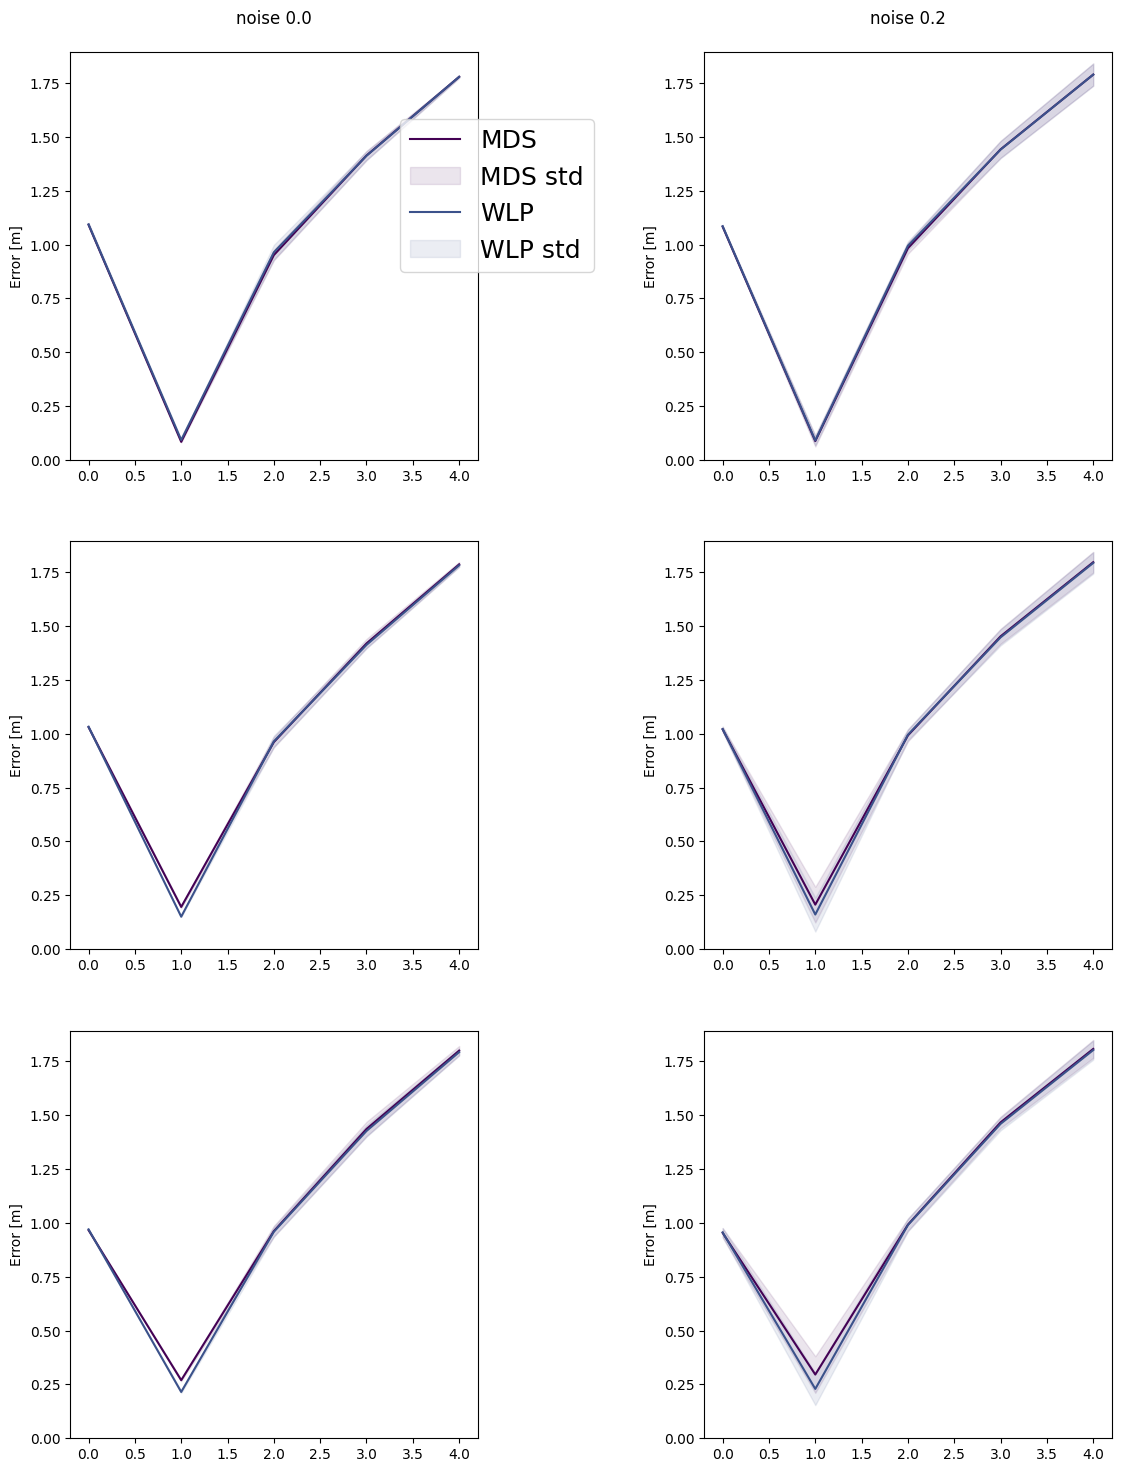

In [83]:
fig, ax = plt.subplots(N_DRONES, len(TESTED_NOISE), figsize=(15, 18))
colors = cm.viridis(np.linspace(0, 1, 5))

y_max = 0.0

for j, noise in enumerate(TESTED_NOISE):
    ax[0, j].set_title(noise, y=1.05)

    for i in range(N_DRONES):

        mds_errors = np.zeros((N_RUN, N_ITERATION))
        wlp_errors = np.zeros((N_RUN, N_ITERATION))

        for k in range(N_RUN):
            for r in range(N_ITERATION):
                run_data = data[noise]['runs'][k]

                mds_errors[k, r] = np.linalg.norm(
                    run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
                )

                wlp_errors[k, r] = np.linalg.norm(
                    run_data['X_wlp_storage'][r, :, i] - run_data['X_storage'][r, :, i]
                )

        # Calculate mean and standard deviation
        mds_mean = np.mean(mds_errors, axis=0)
        mds_std = np.std(mds_errors, axis=0)

        wlp_mean = np.mean(wlp_errors, axis=0)
        wlp_std = np.std(wlp_errors, axis=0)

        y_max = max(y_max, max(max(mds_mean), max(wlp_mean)) + max(max(mds_std), max(wlp_std)))

        # Configure chart
        # ax[i, j].set_xlabel("Iterations [#]")
        ax[i, j].set_ylabel("Error [m]")

        # Plot MDS performances
        ax[i, j].plot(
            range(len(mds_mean)), 
            mds_mean, 
            label="MDS", 
            c=colors[0]
        )
        ax[i, j].fill_between(
            range(len(mds_mean)), 
            mds_mean - mds_std, 
            mds_mean + mds_std, 
            alpha=0.1, 
            color=colors[0]
        )

        # Plot WLP performances
        ax[i, j].plot(
            range(len(wlp_mean)), 
            wlp_mean, 
            label="WLP", 
            c=colors[1]
        )
        ax[i, j].fill_between(
            range(len(wlp_mean)), 
            wlp_mean - wlp_std, 
            wlp_mean + wlp_std, 
            alpha=0.1, 
            color=colors[1]
        )
        ax[i, j].set_box_aspect(1)

for i in range(N_DRONES):
    for j, noise in enumerate(TESTED_NOISE):
        ax[i, j].set_ylim(0,y_max)

fig.legend(
    ["MDS", "MDS std", "WLP", "WLP std"], 
    loc='upper center',  
    ncol=1, 
    fontsize=18,
    bbox_to_anchor=(0.45, 0.85)
)
# plt.savefig(path + 'Plot_pso_test_initialization2.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

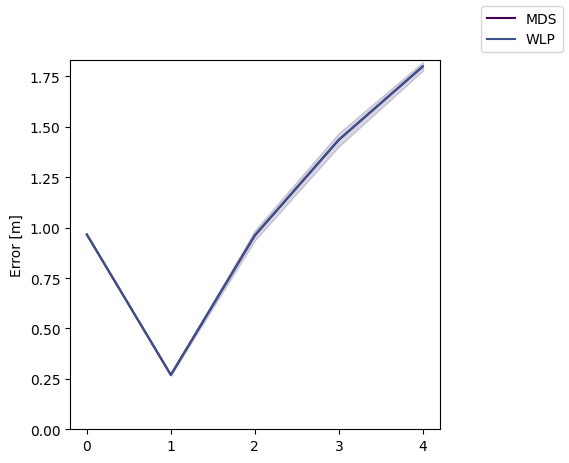

In [86]:
# plot single chart from the previous table specifying the noise and the drone
def plot_single(drone_index, noise):
    fig_single, ax_single = plt.subplots()
    colors = cm.viridis(np.linspace(0, 1, 5))

    i = drone_index

    mds_errors = np.zeros((N_RUN, N_ITERATION))
    wlp_errors = np.zeros((N_RUN, N_ITERATION))

    for k in range(N_RUN):
        for r in range(N_ITERATION):
            run_data = data[noise]['runs'][k]

            mds_errors[k, r] = np.linalg.norm(
                run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
            )
            wlp_errors[k, r] = np.linalg.norm(
                run_data['X_wlp_storage'][r, :, i] - run_data['X_storage'][r, :, i]
            )

    # Calculate mean and standard deviation
    mds_mean = np.mean(mds_errors, axis=0)
    mds_std = np.std(mds_errors, axis=0)

    wlp_mean = np.mean(wlp_errors, axis=0)
    wlp_std = np.std(wlp_errors, axis=0)

    y_max = max(max(mds_mean), max(wlp_mean)) + max(max(mds_std), max(wlp_std))

    # Configure chart
    # ax[i, j].set_xlabel("Iterations [#]")
    ax_single.set_ylabel("Error [m]")
    ax_single.set_ylim(0, y_max)
    
    # Plot MDS performances
    ax_single.plot(
        range(len(mds_mean)), 
        mds_mean, 
        label="MDS", 
        c=colors[0]
    )
    ax_single.fill_between(
        range(len(mds_mean)), 
        mds_mean - mds_std, 
        mds_mean + mds_std, 
        alpha=0.1, 
        color=colors[0]
    )

    # Plot WLP performances
    ax_single.plot(
        range(len(wlp_mean)), 
        mds_mean, 
        label="WLP", 
        c=colors[1]
    )
    ax_single.fill_between(
        range(len(wlp_mean)), 
        wlp_mean - wlp_std, 
        wlp_mean + wlp_std, 
        alpha=0.1, 
        color=colors[1]
    )
    ax_single.set_box_aspect(1)
    
    fig_single.legend()

    plt.show()

plot_single(2, "noise 0.0")

### DON'T KNOW WHAT'S BELOW THE FOLLOWING LINE
--------------------------------------------------------------------

In [5]:
def true_dir_x():
    yaw_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)
    pitch_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)

    true_dir = np.array(
        [math.cos(yaw_err), math.sin(yaw_err), math.sin(pitch_err)]).T

    return true_dir


def true_dir_y():
    yaw_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD) + np.pi/2
    pitch_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)

    true_dir = np.array(
        [math.cos(yaw_err), math.sin(yaw_err), math.sin(pitch_err)]).T

    return true_dir


def true_dir_z():
    yaw_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)
    pitch_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD) + np.pi/2

    true_dir = np.array(
        [math.sin(yaw_err), math.sin(yaw_err), math.sin(pitch_err)]).T

    return true_dir


0
1
2
3


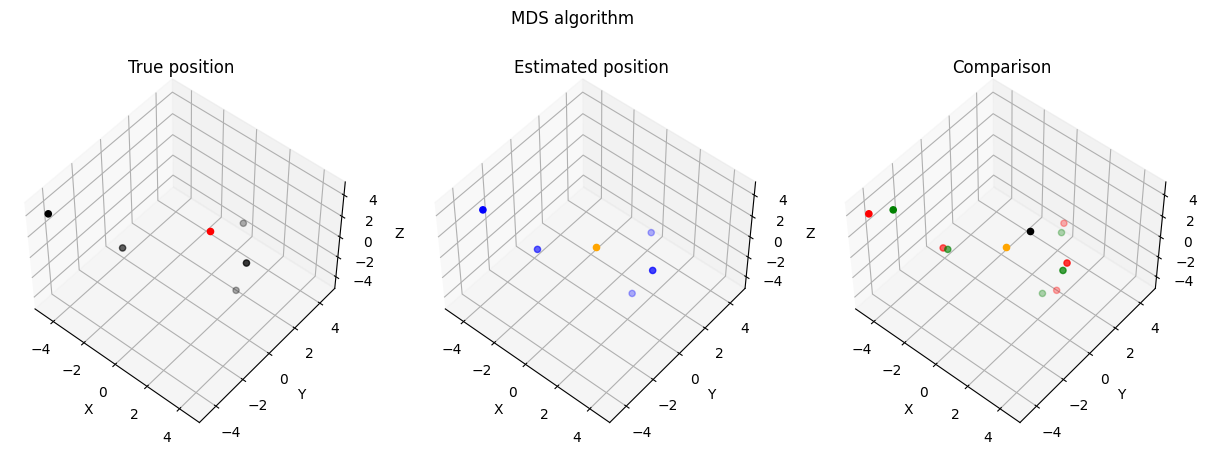

avg squared error MDS:  0.08301098814751118
avg squared error WLP:  0.10261565619090783


In [6]:
step1_coords = [[0], [0], [0]]
step2_coords = [[0], [0], [0]]
step3_coords = [[0], [0], [0]]

alpha = 1
mean, sigma = 0, 0.02
initialize_plot()
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# Initialize UAVs coordinates, randomly
X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])


X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])
for moves in range(4):
    # true_pos =
    dist = TIME + np.random.normal(T_NOISE_MEAN, T_NOISE_STD) * VEL
    print(moves)
    if moves == 0:  # don't move
        ANCHOR1 = np.zeros([3, 1])
        ANCHOR1_T = np.zeros([3, 1])
        X = np.hstack([ANCHOR1_T, X])  # take measurement with ancor in [0,0,0]
        DM1 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

    if moves == 1:  # move along x
        true_pos = dist * true_dir_x()
        step1_coords = np.hstack([step1_coords, np.vstack(true_pos)])
        ANCHOR2 = np.vstack(np.array([1, 0, 0]))
        ANCHOR2_T = np.vstack(true_pos)
        X = np.hstack([ANCHOR2_T, np.delete(X, 0, 1)])
        DM2 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

    elif moves == 2:  # move along y
        true_pos += dist * true_dir_y()
        step2_coords = np.hstack([step2_coords, np.vstack(true_pos)])
        ANCHOR3 = np.vstack(np.array([1, 1, 0]))
        ANCHOR3_T = np.vstack(true_pos)
        X = np.hstack([ANCHOR3_T, np.delete(X, 0, 1)])
        DM3 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

    elif moves == 3:  # move along z
        true_pos += dist * true_dir_z()
        step3_coords = np.hstack([step3_coords, np.vstack(true_pos)])
        ANCHOR4 = np.vstack(np.array([1, 1, 1]))
        ANCHOR4_T = np.vstack(true_pos)
        X = np.hstack([ANCHOR4_T, np.delete(X, 0, 1)])
        DM4 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

# Assemble the distance information in one unique matrix
DM = combine_matrices(DM1, DM2, DM3, DM4, ANCHOR1, ANCHOR2, ANCHOR3, ANCHOR4)

# Store the anchor and virtual anchors position into a coordinates array
anchor_pos = np.hstack([ANCHOR1, ANCHOR2, ANCHOR3, ANCHOR4])

# Estimate the fleet coordinates
X_hat_mds = MDS(DM, anchor_pos)
X_hat_wlp = WLP(DM, anchor_pos)

# Plot the scenario
# plot_uavs(true_coords=X, estimated_coords=X_hat_mds)
plot_uavs(true_coords=X, estimated_coords=X_hat_wlp)

mds_sq_err = (X-X_hat_mds)
wlp_sq_err = (X-X_hat_wlp)

print("avg squared error MDS: ", np.average(mds_sq_err))
print("avg squared error WLP: ", np.average(wlp_sq_err))


In [7]:
step1_coords = [[0], [0], [0]]
step2_coords = [[0], [0], [0]]
step3_coords = [[0], [0], [0]]

MDS_err = []
WLP_err = []

alpha = 1
mean, sigma = 0, 0.02
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# Initialize UAVs coordinates, randomly
X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])

for cnt in range(100):
    X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])
    for moves in range(4):
        # true_pos =
        dist = TIME + np.random.normal(T_NOISE_MEAN, T_NOISE_STD) * VEL
        if moves == 0:  # don't move
            ANCHOR1 = np.zeros([3, 1])
            ANCHOR1_T = np.zeros([3, 1])
            # take measurement with ancor in [0,0,0]
            X = np.hstack([ANCHOR1_T, X])
            DM1 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

        if moves == 1:  # move along x
            true_pos = dist * true_dir_x()
            step1_coords = np.hstack([step1_coords, np.vstack(true_pos)])
            ANCHOR2 = np.vstack(np.array([1, 0, 0]))
            ANCHOR2_T = np.vstack(true_pos)
            X = np.hstack([ANCHOR2_T, np.delete(X, 0, 1)])
            DM2 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

        elif moves == 2:  # move along y
            true_pos += dist * true_dir_y()
            step2_coords = np.hstack([step2_coords, np.vstack(true_pos)])
            ANCHOR3 = np.vstack(np.array([1, 1, 0]))
            ANCHOR3_T = np.vstack(true_pos)
            X = np.hstack([ANCHOR3_T, np.delete(X, 0, 1)])
            DM3 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

        elif moves == 3:  # move along z
            true_pos += dist * true_dir_z()
            step3_coords = np.hstack([step3_coords, np.vstack(true_pos)])
            ANCHOR4 = np.vstack(np.array([1, 1, 1]))
            ANCHOR4_T = np.vstack(true_pos)
            X = np.hstack([ANCHOR4_T, np.delete(X, 0, 1)])
            DM4 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

    # Assemble the distance information in one unique matrix
    DM = combine_matrices(DM1, DM2, DM3, DM4, ANCHOR1,
                          ANCHOR2, ANCHOR3, ANCHOR4)

    # Store the anchor and virtual anchors position into a coordinates array
    anchor_pos = np.hstack([ANCHOR1, ANCHOR2, ANCHOR3, ANCHOR4])

    # Estimate the fleet coordinates
    X_hat_mds = MDS(DM, anchor_pos)
    X_hat_wlp = WLP(DM, anchor_pos)

    # compute squared error
    mds_sq_err = np.average((X-X_hat_mds)**2)
    wlp_sq_err = np.average((X-X_hat_wlp)**2)
    # save error
    MDS_err.append(mds_sq_err)
    WLP_err.append(wlp_sq_err)

print("avg squared error MDS: ", np.average(MDS_err))
print("avg squared error WLP: ", np.average(WLP_err))


avg squared error MDS:  0.22350678770147944
avg squared error WLP:  0.357290871801935


In [8]:
# Sample data (replace this with your own 3D data)
x = np.hstack([step1_coords[0], step2_coords[0], step3_coords[0]])
y = np.hstack([step1_coords[1], step2_coords[1], step3_coords[1]])
z = np.hstack([step1_coords[2], step2_coords[2], step3_coords[2]])

# Create a trace for the 3D scatter plot
scatter_trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color='blue',        # You can customize the color of the markers here
        opacity=0.8,
    )
)

# Create the layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        zaxis=dict(title='Z-axis')
    ),
    title='Interactive 3D Scatter Plot'
)

# Create the figure and add the trace and layout
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the interactive plot
fig.show()
